# Réseau de neurones profond pour la classification d’images : Application
À la fin de ce notebook, vous aurez terminé le dernier exercice de programmation du premier chapitre.

Pour construire votre classifieur chat / non-chat, vous allez utiliser les fonctions des exercices précédents pour bâtir un réseau de neurones profond.
Avec un peu de chance, vous constaterez une amélioration de la précision par rapport à votre implémentation précédente en régression logistique.

**Après cet exercice, vous serez capable de :**
Construire et entraîner un réseau de neurones profond à L couches, et l’appliquer à un problème d’apprentissage supervisé.

## Table of Contents
- [1 - Packages](#1)
- [2 - Load and Process the Dataset](#2)
- [3 - Model Architecture](#3)
    - [3.1 - 2-layer Neural Network](#3-1)
    - [3.2 - L-layer Deep Neural Network](#3-2)
    - [3.3 - General Methodology](#3-3)
- [4 - Two-layer Neural Network](#4)
    - [Exercise 1 - two_layer_model](#ex-1)
    - [4.1 - Train the model](#4-1)
- [5 - L-layer Neural Network](#5)
    - [Exercise 2 - L_layer_model](#ex-2)
    - [5.1 - Train the model](#5-1)
- [6 - Results Analysis](#6)
- [7 - Test with your own image (optional/ungraded exercise)](#7)

<a name='1'></a>
## 1 - Packages

Commencez par importer tous les packages dont vous aurez besoin au cours de cet exercice.

- [numpy](https://www.numpy.org/) est la bibliothèque fondamentale pour le calcul scientifique avec Python.

- [matplotlib](http://matplotlib.org) est une bibliothèque permettant de tracer des graphes en Python.

- [h5py](http://www.h5py.org) est un package utilisé pour manipuler des ensembles de données stockés dans des fichiers au format H5.

- [PIL](http://www.pythonware.com/products/pil/) et [scipy](https://www.scipy.org/)  sont utilisés ici pour tester votre modèle avec votre propre image à la fin de l’exercice.

- Le module `dnn_app_utils` contient les fonctions que vous avez implémentées dans l’exercice "Construire votre réseau de neurones profond étape par étape" et les rend disponibles dans ce notebook.

L’instruction `np.random.seed(1)` est utilisée pour garder la cohérence des tirages aléatoires.

In [42]:
### v1.1

In [43]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 - Charger et traiter le jeu de données

Vous allez utiliser le même jeu de données "Chat vs Non-Chat" que dans l’exercice "Régression logistique comme réseau de neurones" (TP 1).
Le modèle que vous aviez construit à ce moment-là atteignait 70 % de précision sur le jeu de test pour la classification des images de chats et non-chats.
Espérons que votre nouveau modèle obtienne de meilleures performances !

**Énoncé du problème**: Vous disposez d’un fichier de données (data.h5) contenant :
    - un ensemble d’apprentissage de `m_train` images étiquetées comme chat (1) ou non-chat (0),
    - un ensemble de test de `m_test` images étiquetées également,
    - chaque image est de dimension (num_px, num_px, 3), où 3 représente les trois canaux de couleur (RGB).

Familiarisons-nous un peu plus avec ce jeu de données.
Chargez les données en exécutant la cellule ci-dessous.

In [44]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

Le code suivant affichera une image du jeu de données. N'hésitez pas à modifier l'index et à exécuter la cellule plusieurs fois pour consulter d'autres images. 

y = 0. It's a non-cat picture.


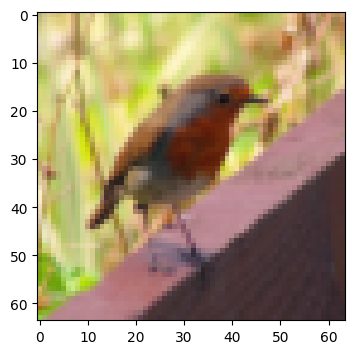

In [45]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [46]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


## Comme d'habitude, vous devez reshape et standardiser les images avant de les fournir au réseau de neurones.
Le code correspondant est donné dans la cellule ci-dessous.
<img src="images/imvectorkiank.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [47]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**Note**:
$12,288$ equals $64 \times 64 \times 3$, which is the size of one reshaped image vector.

<a name='3'></a>
## 3 - Architecture du Modèle 

<a name='3-1'></a>
### 3.1 - Réseau de neurones à 2 couches

Maintenant que vous êtes familiarisé avec le jeu de données, il est temps de construire un réseau de neurones profond pour distinguer les images de chats de celles qui n’en sont pas !

Vous allez construire deux modèles différents :

- Un réseau de neurones à 2 couches

- Un réseau de neurones profond à L couches

Ensuite, vous comparerez les performances de ces deux modèles, et vous testerez différentes valeurs de $L$


Examinons les deux architectures :

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 2</b>: 2-layer neural network. <br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.</font></center></caption>

<u><b>Architecture détaillée de la figure 2 :</b></u>:
- L’entrée est une image de taille (64, 64, 3) qui est aplatie en un vecteur de taille $(12288,1)$. 
- Le vecteur correspondant : $[x_0,x_1,...,x_{12287}]^T$ est ensuite multiplié par la matrice de poids $W^{[1]}$ de taille $(n^{[1]}, 12288)$.
- Ajoutez ensuite un terme de biais et appliquez la fonction ReLU pour obtenir le vecteur suivant : $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multipliez le vecteur obtenu par : $W^{[2]}$ et ajoutez l’ordonnée à l’origine (biais). 
- Enfin, appliquez la fonction sigmoïde au résultat. S’il est supérieur à 0,5, classez l’image comme représentant un chat.

<a name='3-2'></a>
### 3.2 - L-layer Deep Neural Network

Il est assez difficile de représenter un réseau neuronal profond à L couches en utilisant la représentation ci-dessus. Cependant, voici une représentation simplifiée du réseau :

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 3</b>: L-layer neural network. <br> The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID</font></center></caption>

<u><b>Architecture détaillée de la figure 3</b></u>:
- L’entrée est une image de taille (64, 64, 3) qui est aplatie en un vecteur de taille (12288, 1).
- Le vecteur correspondant : $[x_0,x_1,...,x_{12287}]^T$ est ensuite multiplié par la matrice de poids $W^{[1]}$ puis on ajoute le biais $b^{[1]}$. Le résultat est appelé l’unité linéaire.
- Ensuite, prenez le relu de l'unité linéaire. Ce processus peut être répété plusieurs fois pour chaque unité $(W^{[l]}, b^{[l]})$ Selon l'architecture du modèle.
- Enfin, prenez la sigmoïde de l'unité linéaire finale. Si elle est supérieure à 0,5, classez-la comme un chat.

<a name='3-3'></a>
### 3.3 - Méthodologie Générale

Comme d'habitude, vous allez suivre la méthodologie de l'apprentissage profond pour construire le modèle :

1. Initialiser les paramètres / Définir les hyperparamètres

2. Boucle sur num_iterations :
   
    a. Forward Propagation  
    b. Calcul de la fonction de coût  
    c. back-propagation   
    d. Mise à jour des paramètres (en utilisant les paramètres et les gradients de la rétropropagation)

4. Utiliser les paramètres entraînés pour prédire les étiquettes

Allez-y maintenant et implémentez ces deux modèles !

<a name='4'></a>
## 4 - Réseau de neurones à 2 couches

<a name='ex-1'></a>
### Exercise 1 - two_layer_model 

Utilisez les fonctions d’aide que vous avez implémentées dans le TP précédent pour construire un réseau de neurones à 2 couches avec la structure suivante : *LINEAR -> RELU -> LINEAR -> SIGMOID*. Les fonctions et leurs paramètres d’entrée sont :
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [48]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [49]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2])
    
    # YOUR CODE ENDS HERE
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        #(≈ 2 lines of code)
        # A1, cache1 = ...
        # A2, cache2 = ...
        # YOUR CODE STARTS HERE
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        # YOUR CODE ENDS HERE
        
        # Compute cost
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(A2, Y)
        
        # YOUR CODE ENDS HERE
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        # dA1, dW2, db2 = ...
        # dA0, dW1, db1 = ...
        # YOUR CODE STARTS HERE
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # YOUR CODE ENDS HERE
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        #(approx. 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [50]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))

two_layer_model_test(two_layer_model)

Cost after iteration 1: 0.6926114346158595
Cost after first iteration: 0.693049735659989
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 2: 0.6524135179683452
 All tests passed.


**Expected output:**

```
cost after iteration 1 must be around 0.69
```

<a name='4-1'></a>
### 4.1 - Entrainer le modèle 

Si votre code a fonctionné dans la cellule précédente, exécutez la cellule ci-dessous pour entraîner vos paramètres.

- Le coût devrait diminuer à chaque itération.

- L’exécution de 2500 itérations peut prendre jusqu’à 5 minutes.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203887
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.33942815383664127
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.24681768210614832
Cost after iteration 1400: 0.19850735037466086
Cost after iteration 1500: 0.17448318112556682
Cost after iteration 1600: 0.1708076297809607
Cost after iteration 1700: 0.11306524562164731
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.0743907870431908
Cost after iteration 2100: 0.0663074813

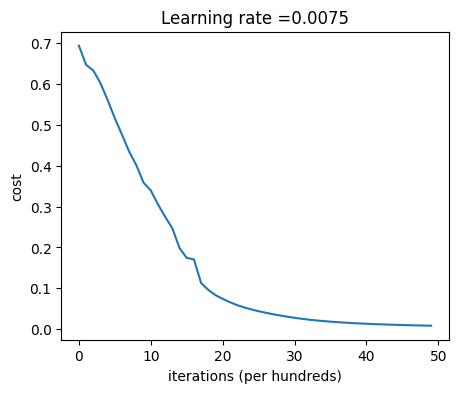

In [51]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 5000, print_cost=True)
plot_costs(costs, learning_rate)

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.04421498215868956 </td>
    </tr>
</table>

Super ! Vous avez entraîné le modèle avec succès. Heureusement que vous avez construit une implémentation vectorisée !
Sinon, l’entraînement aurait pu prendre 10 fois plus de temps.

Maintenant, vous pouvez utiliser les paramètres entraînés pour classer les images du jeu de données.
Pour voir vos prédictions sur les ensembles d’apprentissage et de test, exécutez la cellule ci-dessous.

In [52]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Expected Output**:
<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.9999999999999998 </td>
    </tr>
</table>

In [53]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7000000000000001


**Expected Output**:

<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.72 </td>
    </tr>
</table>

### Félicitations ! Il semble que votre réseau de neurones à 2 couches offre de meilleures performances (72 %) que l’implémentation en régression logistique (70 %) du TP 1. Voyons maintenant si vous pouvez faire encore mieux avec un modèle à $L$ couches.

**Remarque** :
Vous pourriez remarquer que faire tourner le modèle avec moins d’itérations (par exemple 1500) donne une meilleure précision sur l’ensemble de test.
C’est ce qu’on appelle le "early stopping" (arrêt anticipé), et vous en entendrez parler davantage dans le chapitre suivant.
L’early stopping est une méthode pour éviter le surapprentissage (overfitting).

<a name='5'></a>
## 5 - L-layer Neural Network

<a name='ex-2'></a>
### Exercise 2 - L_layer_model 

Use the helper functions you implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [54]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [55]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters_deep(layers_dims)
    
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        AL, caches = L_model_forward(X, parameters)
        
        # YOUR CODE ENDS HERE
        
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(AL, Y)
        
        # YOUR CODE ENDS HERE
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        # YOUR CODE STARTS HERE
        grads = L_model_backward(AL, Y, caches)
        
        # YOUR CODE ENDS HERE
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [56]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

L_layer_model_test(L_layer_model)

Cost after iteration 0: 0.7717493284237686
Cost after first iteration: 0.7717493284237686
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 2: 0.7063462654190897
 All tests passed.


<a name='5-1'></a>
### 5.1 - Entrainer le modèle 

Si votre code a fonctionné dans la cellule précédente, exécutez la cellule ci-dessous pour entraîner votre modèle en tant que réseau de neurones à 4 couches.

- Le coût devrait diminuer à chaque itération.

- L’exécution de 2500 itérations peut prendre jusqu’à 5 minutes.

In [57]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 5000, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766851
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.31518698886006163
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.16118854665827748
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005212
Cost after iteration 2000: 0.11382060668633712
Cost after iteration 2100: 0.107839

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.088439 </td>
    </tr>
</table>

In [58]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9904306220095691


**Expected Output**:

<table>
    <tr>
    <td>
        <b>Train Accuracy</b>
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [59]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78


**Expected Output**:

<table> 
    <tr>
        <td> <b>Test Accuracy</b></td>
        <td> 0.8 </td>
    </tr>
</table>

### Félicitations ! Il semble que votre réseau de neurones à 4 couches offre de meilleures performances (80 %) que votre réseau à 2 couches (72 %), sur le même jeu de test.

C’est un excellent résultat pour cette tâche. Bravo !

<a name='6'></a>
##  6 - Analyse des résultats
Commencez par examiner quelques images que le modèle à L couches a mal classées.
Cela vous permettra de visualiser certaines erreurs d’étiquetage.

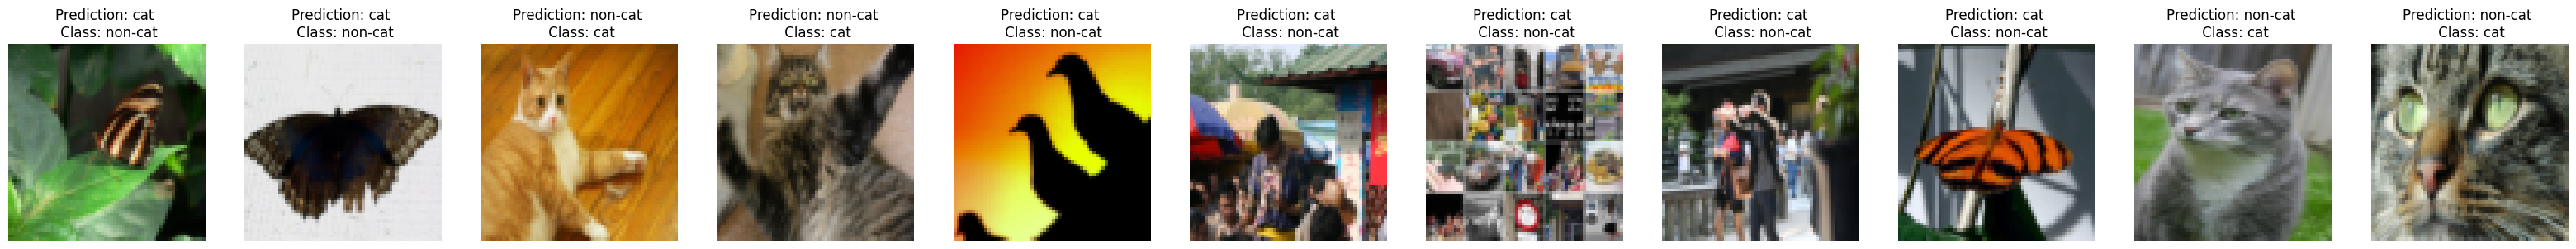

In [60]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Quelques types d’images sur lesquelles le modèle a tendance à mal performer :**

- Le corps du chat est dans une position inhabituelle

- Le chat apparaît sur un fond de couleur similaire

- Le chat a une couleur ou une espèce inhabituelle

- Angle de prise de vue

- Luminosité de l’image

- Variation d’échelle (le chat est très grand ou très petit dans l’image)

### Félicitations pour avoir terminé ce devoir !
Vous venez de concevoir et d’entraîner un réseau de neurones profond à L couches, et de l’appliquer pour distinguer les chats des non-chats — une tâche très sérieuse et importante en apprentissage profond.

À ce stade, vous avez également terminé tous les exercices du chapitre 1.

<a name='7'></a>
## 7 - Tester avec votre propre image (exercice facultatif / non noté)
À partir de maintenant, si vous le souhaitez, vous pouvez tester votre propre image pour voir la prédiction de votre modèle. Pour cela, suivez les étapes suivantes :

1. Ajoutez votre image dans le répertoire du notebook Jupyter, dans le dossier « images ».
2. Modifiez le nom de l’image dans le code ci-dessous.
3. Exécutez le code et vérifiez si l’algorithme donne la bonne réponse (1 = chat, 0 = non-chat) ! 

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


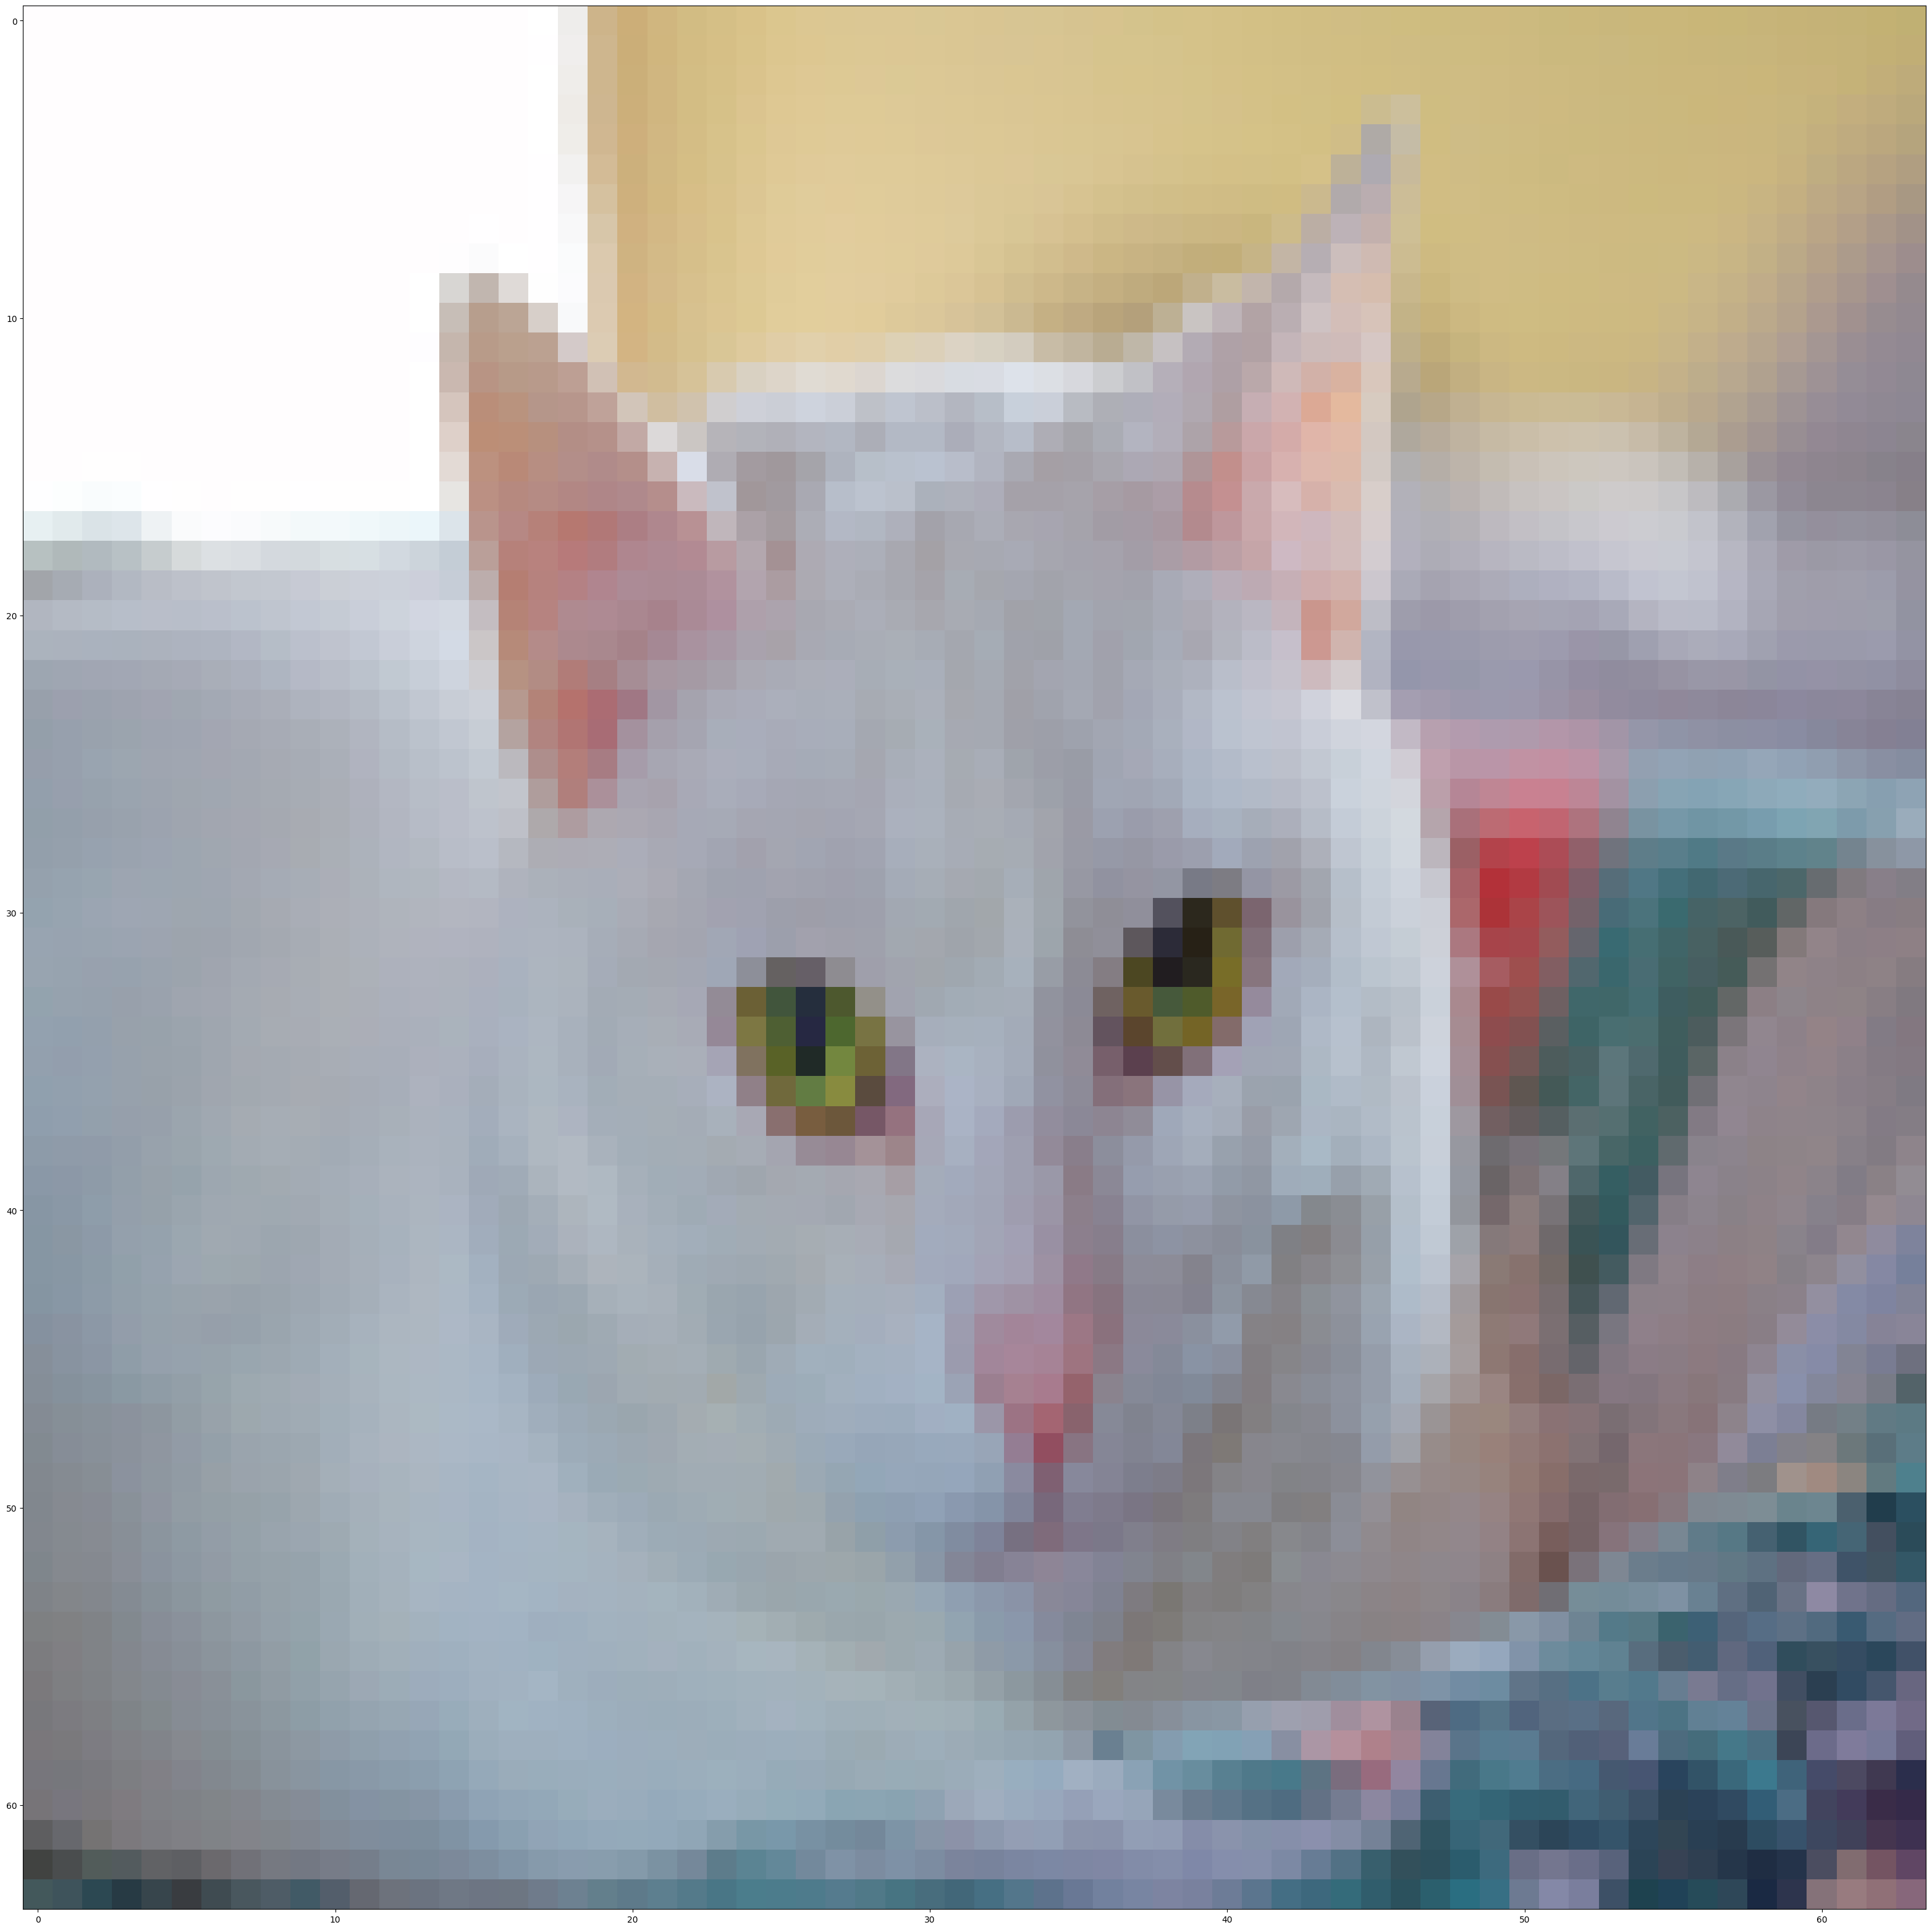

In [61]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")